# Импорты и самопись

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import gc
import re
from urllib.request import urlopen

import numpy as np
import scipy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score

import lightgbm as lgb

np.random.seed(16777216)

In [2]:
def ndcg_score_(y_true, y_pred):
    return ndcg_score([np.exp(y_true - 1)], y_pred)

In [3]:
class ALS:
    def __init__(self,
                 csr_user_item_rate,
                 random_seed=16777216):
        self.R = csr_user_item_rate
        self.u_cnt = self.R.shape[0]
        self.i_cnt = self.R.shape[1]
        np.random.seed(random_seed)

    def fit(self,
            latent_features=10,
            lambda_coef=0.1,
            n_iter=5):
        U = scipy.sparse.csr_matrix(np.random.rand(self.u_cnt, latent_features))
        I = scipy.sparse.csr_matrix(np.random.rand(self.i_cnt, latent_features))
        eye = scipy.sparse.csr_matrix(np.eye(latent_features) * lambda_coef)
        
        for itr in range(n_iter):
            a = scipy.sparse.linalg.inv(U.T * U + eye)
            b = (self.R.T * U).T
            I = (a * b).T
            
            a = scipy.sparse.linalg.inv(I.T * I + eye)
            b = (self.R * I).T
            U = (a * b).T
        
        self.f_cnt = latent_features
        self.U = U
        self.I = I
        self.UTU = scipy.sparse.linalg.inv(U.T * U + eye)
        self.ITI = scipy.sparse.linalg.inv(I.T * I + eye)
        del self.R
    
    def recommend_train(self,
                        user=0,
                        item_list=None):
        if item_list is None:
            p = (self.U[user, :] * self.I.T)
        else:
            p = (self.U[user, :] * self.I[item_list, :].T)

        return p.toarray()
    
    def recommend(self,
                  csr_user_item_rate,
                  item_list=None):
        self.r = csr_user_item_rate
        self.r.resize((csr_user_item_rate.shape[0], self.i_cnt))
        self.u = (self.ITI * (self.r * self.I).T).T
        
        if item_list is None:
            p = (self.u * self.I.T)
        else:
            p = (self.u * self.I[item_list,:].T)
        
        return p.toarray()

In [4]:
class MemoryReducer:
    def __init__(self):
        self.int8_min = np.iinfo(np.int8).min
        self.int8_max = np.iinfo(np.int8).max
        self.int16_min = np.iinfo(np.int16).min
        self.int16_max = np.iinfo(np.int16).max
        self.int32_min = np.iinfo(np.int32).min
        self.int32_max = np.iinfo(np.int32).max
        self.float16_min = np.finfo(np.float16).min
        self.float16_max = np.finfo(np.float16).max
        self.float32_min = np.finfo(np.float32).min
        self.float32_max = np.finfo(np.float32).max

    def shrink_column(self,
                      col):
        is_int = col.dtypes.name[:3] == 'int'
        is_float = col.dtypes.name[:3] == 'flo'

        if is_int:
            c_min = col.min()
            c_max = col.max()
            if c_min > self.int8_min and c_max < self.int8_max:
                col = col.astype(np.int8)
            elif c_min > self.int16_min and c_max < self.int16_max:
                col = col.astype(np.int16)
            elif c_min > self.int32_min and c_max < self.int32_max:
                col = col.astype(np.int32)
        elif is_float:
            c_min = col.min()
            c_max = col.max()
            if c_min > self.float16_min and c_max < self.float16_max:
                col = col.astype(np.float16)
            elif c_min > self.float32_min and c_max < self.float32_max:
                col = col.astype(np.float32)
        return col

    def reduce(self,
               df,
               n_threads=1):
        df = pd.concat([self.shrink_column(df[col]) for col in df.columns],
                       axis=1)
        return df

# Считывание данных
Тэги указаны не для всех фильмов, а также не будут указаны в задании 6, поэтому в датасет не включены

In [5]:
rating = pd.read_csv('data/rating.csv')
movie = pd.read_csv('data/movie.csv')
link = pd.read_csv('data/link.csv')

In [6]:
rating

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00
20000259,138493,69526,4.5,2009-12-03 18:31:48
20000260,138493,69644,3.0,2009-12-07 18:10:57
20000261,138493,70286,5.0,2009-11-13 15:42:24


In [7]:
movie

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [8]:
link

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
27273,131254,466713,4436.0
27274,131256,277703,9274.0
27275,131258,3485166,285213.0
27276,131260,249110,32099.0


# Приведение данных в порядок
## Фильмы

Функция, для заполнения года по страничке на *imdb.com*

In [9]:
def imdb_year(imdb_id,
              key_words=['Series', 'Episode aired'],
              max_length=50):
    link = str(imdb_id).rjust(7, '0')
    l = 'https://imdb.com/title/tt' + link + '/'
    imdb_page_html = urlopen(l).read().decode('utf-8')
    start = imdb_page_html.find('<h1')
    end = imdb_page_html[start:].find('</h1>') + start
    year_str = re.search('[0-9]{4}', imdb_page_html[start:end])
    if year_str is not None:
        return int(year_str.group(0))
    else:
        srch = '|'.join(key_words)
        start = re.search(srch, imdb_page_html).start()
        end = start + max_length
        year_str = re.search('[0-9]{4}', imdb_page_html[start:end])
        return int(year_str.group(0))

In [10]:
movie = movie.merge(right=link,
                    how='left',
                    on='movieId')
del link

Нормализация поля **Title** и извлечение года. В качестве признака будет использоваться десятилетие

One-hot encoding жанров

In [11]:
movie['title'] = movie['title'].str.replace('[ "]$', '')
movie['title'] = movie['title'].str.replace('(\()([0-9]{4})(\)\))$', '(\\2)')
movie['title'] = movie['title'].str.replace('(\()([0-9]{4})([-–] \))$', '(\\2)')
movie['title'] = movie['title'].str.replace('(\()([0-9]{4})([-–]\))$', '(\\2)')

movie['title'] = movie['title'].str.replace('(\()([0-9]{4})([-–][0-9]{4}\))$', '(\\2)')

is_year_idx = movie['title'].str[-6:].str.match('\([0-9]{4}\)')
movie['year'] = 0
movie['year'][is_year_idx] = movie['title'][is_year_idx].str[-5:-1].astype(int)
movie['year'][~is_year_idx] = movie['imdbId'][~is_year_idx].apply(imdb_year)

movie['decade'] = movie['year'] // 10 * 10

movie['title'][is_year_idx] = movie['title'][is_year_idx].str[:-6].str.replace(' $', '')

one_hot_genres = movie['genres'].replace('(no genres listed)', np.nan).str.get_dummies()
movie = movie.drop(columns='genres').join(one_hot_genres)

Исключаем фильмы, которые получили пять или менее оценок

In [12]:
rc = rating.groupby('movieId').count()['userId']
mr = pd.Series(rc[rc > 5].index, name='movieId')

In [13]:
movie = movie.merge(mr, on='movieId')
movie.index = range(movie.shape[0])

In [14]:
movie

,movieId,title,imdbId,tmdbId,year,decade,Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,114709,862.0,1995,1990,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,113497,8844.0,1995,1990,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,113228,15602.0,1995,1990,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,114885,31357.0,1995,1990,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,113041,11862.0,1995,1990,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17514,129937,Run All Night,2199571,241554.0,2015,2010,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
17515,130073,Cinderella,1661199,150689.0,2015,2010,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
17516,130075,Frozen Fever,4007502,326359.0,2015,2010,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
17517,130490,Insurgent,2908446,262500.0,2015,2010,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0


## Рейтинги
В теории можно попробовать обучиться на экспоненту рейтинга (поскольку чем выше оценка, тем она важнее)

In [15]:
rating['rating_exp'] = np.exp(rating['rating'])
targ = 'rating'

In [16]:
rating = rating.merge(mr, on='movieId')
rating.index = range(rating.shape[0])

In [17]:
rating

,userId,movieId,rating,timestamp,rating_exp
0,1,2,3.5,2005-04-02 23:53:47,33.115452
1,5,2,3.0,1996-12-25 15:26:09,20.085537
2,13,2,3.0,1996-11-27 08:19:02,20.085537
3,29,2,3.0,1996-06-23 20:36:14,20.085537
4,34,2,3.0,1996-10-28 13:29:44,20.085537
...,...,...,...,...,...
19979889,114406,88674,1.0,2011-08-05 09:41:02,2.718282
19979890,123297,88674,5.0,2011-10-08 18:40:13,148.413159
19979891,130622,88674,2.5,2011-08-04 07:06:37,12.182494
19979892,134567,88674,0.5,2011-08-10 05:51:12,1.648721


# Моделирование
## Разбиение на подвыборки
Преобразуем индексы фильмов и пользователей, чтобы избежать избыточно большой матрицы

In [18]:
movie_index_to_id = {i: j for i, j in zip(movie.index, movie.movieId)}
movie_id_to_index = {j: i for i, j in zip(movie.index, movie.movieId)}

In [19]:
movie['movieId_'] = movie['movieId'].map(movie_id_to_index)
rating['movieId_'] = rating['movieId'].map(movie_id_to_index)

Проверяем, что не осталось пользователей, у которых слишком мало данных оценок

In [20]:
users = rating.groupby('userId').agg({'movieId_': 'count'}).reset_index()
users[users['movieId_'] < 15]

,userId,movieId_


Сначала разбиваем выборку по пользователям на тренировочную и тестовую части:
* Тренировочная участвует в построении модели и оптимизации ее гиперпараметров
* Тестовая часть используется только для оценки получившейся модели

Каждую из частей разбиваем на тренировочную и валидационную:
* Тренировочная - известные оценки для моделирования
* Валидаионная - оценки, на основе которых вычисляется метрика
    * Для тренировочной подвыборки участвует в подборе гиперпараметров
    * Для тестовой подвыборки участвует в оценке итогового качества модели

In [21]:
tr_idx, te_idx = train_test_split(range(users.shape[0]), test_size=0.2)

train_users = users.iloc[tr_idx]['userId'].sort_values()
train_users.index = range(train_users.shape[0])
train = rating.merge(train_users, on='userId')
train.index = range(train.shape[0])

test_users = users.iloc[te_idx]['userId'].sort_values()
test_users.index = range(test_users.shape[0])
test = rating.merge(test_users, on='userId')
test.index = range(test.shape[0])

In [22]:
train_users_index_to_id = {i: j for i, j in zip(train_users.index, train_users)}
train_users_id_to_index = {j: i for i, j in zip(train_users.index, train_users)}

train['userId_'] = train['userId'].map(train_users_id_to_index)

In [23]:
trtr_idx, trva_idx = train_test_split(range(train.shape[0]), test_size=0.3, stratify=train['userId_'])
train_t = train.iloc[trtr_idx]
train_v = train.iloc[trva_idx]
train_csr = scipy.sparse.csr_matrix(((train[targ]).astype(np.float16), (train['userId_'], train['movieId_'])))
train_t_csr = scipy.sparse.csr_matrix(((train_t[targ]).astype(np.float16), (train_t['userId_'], train_t['movieId_'])))
train_t_csr.resize((train_t_csr.shape[0], movie.shape[0]))
train_v_csr = scipy.sparse.csr_matrix(((train_v[targ]).astype(np.float16), (train_v['userId_'], train_v['movieId_'])))
train_v_csr.resize((train_v_csr.shape[0], movie.shape[0]))

In [24]:
test_users_index_to_id = {i: j for i, j in zip(test_users.index, test_users)}
test_users_id_to_index = {j: i for i, j in zip(test_users.index, test_users)}

test['userId_'] = test['userId'].map(test_users_id_to_index)

In [25]:
tetr_idx, teva_idx = train_test_split(range(test.shape[0]), test_size=0.3, stratify=test['userId_'])
test_t = test.iloc[tetr_idx]
test_v = test.iloc[teva_idx]
test_t_csr = scipy.sparse.csr_matrix(((test_t[targ]).astype(np.float16), (test_t['userId_'], test_t['movieId_'])))
test_t_csr.resize((test_t_csr.shape[0], movie.shape[0]))
test_v_csr = scipy.sparse.csr_matrix(((test_v[targ]).astype(np.float16), (test_v['userId_'], test_v['movieId_'])))
test_v_csr.resize((test_v_csr.shape[0], movie.shape[0]))

## Коллаборативная фильтрация
Для моделирования используется самописный Explicit-ALS

По-очереди подбираются гиперпараметры:
* Количество скрытых признаков
* Коэффициент регуляризации
* Количество итераций

Для оценки результата используется метрика NDCG. Метрика выбрана из-за наилучшего (по субъективному мнению автора) соответствия задаче:
* NDCG лучше, чем RMSE (и другие регрессионные метрики), поскольку ближе к бизнес-задаче, в которой нам необходимо не угадать оценку фильма, а отсортировать фильмы по оценке
* NDCG лучше, чем MAP, поскольку у нас есть данные о "релевантности документов" - их рейтингах, чем было бы странно не воспользоваться
* NDCG лучше, чем DCG, поскольку нормирована (пусть и только сверху, из-за чего цифра выглядит круче реальности)
* NDCG, а не NDCG@k, поскольку у нас не так много фильмов с оценками для каждого пользователя

In [26]:
latent_features = [5, 10, 15, 20, 25]
scores_lf = []
for lf in latent_features:
    als = ALS(train_t_csr)
    als.fit(latent_features=lf)
    
    ndcg = 0
    for i in range(train.userId_.max()):
        ndcg += ndcg_score_(train_v_csr[i].data, als.recommend_train(i, train_v_csr[i].nonzero()[1]))
    ndcg /= train.userId_.max()
    scores_lf += [ndcg]

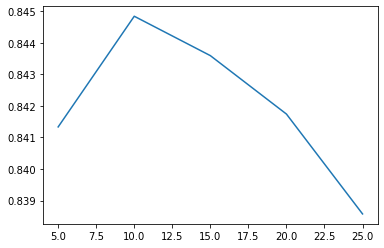

In [27]:
lf = latent_features[np.argmax(scores_lf)]
plt.plot(latent_features, scores_lf)
plt.show()

In [28]:
lambda_coef = [0, 0.01, 0.05, 0.1, 0.5]
scores_lc = []
for lc in lambda_coef:
    als = ALS(train_t_csr)
    als.fit(latent_features=lf,
            lambda_coef=lc)
    
    ndcg = 0
    for i in range(train.userId_.max()):
        ndcg += ndcg_score_(train_v_csr[i].data, als.recommend_train(i, train_v_csr[i].nonzero()[1]))
    ndcg /= train.userId_.max()
    scores_lc += [ndcg]

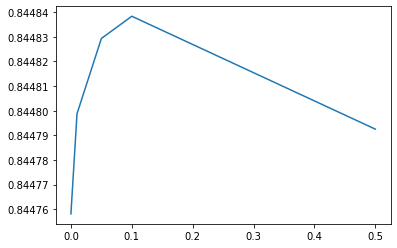

In [29]:
lc = lambda_coef[np.argmax(scores_lc)]
plt.plot(lambda_coef, scores_lc)
plt.show()

In [30]:
n_iter = [5, 10, 15]
scores_ni = []
for ni in n_iter:
    als = ALS(train_t_csr)
    als.fit(latent_features=lf,
            lambda_coef=lc,
            n_iter=ni)
    
    ndcg = 0
    for i in range(train.userId_.max()):
        ndcg += ndcg_score_(train_v_csr[i].data, als.recommend_train(i, train_v_csr[i].nonzero()[1]))
    ndcg /= train.userId_.max()
    scores_ni += [ndcg]

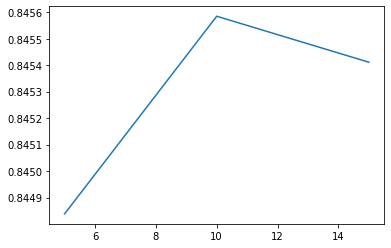

In [31]:
ni = n_iter[np.argmax(scores_ni)]
plt.plot(n_iter, scores_ni)
plt.show()

Финальную коллаборативную модель для использования на бою (хоть и был солдат бумажный) строим на всех тренировочных данных

In [32]:
del als
gc.collect()
model_collaborative = ALS(train_csr)
model_collaborative.fit(latent_features=lf,
                        lambda_coef=lc,
                        n_iter=ni)

Строим модель для участия в обучении смешанной модели

In [33]:
model_collaborative_t = ALS(train_t_csr)
model_collaborative_t.fit(latent_features=lf,
                          lambda_coef=lc,
                          n_iter=ni)

NDCG на тестовой выборке похоже на NDCG на валидации. Приятно

In [34]:
ndcgs_collaborative = []
for i in range(test.userId_.max()):
    ndcgs_collaborative += [ndcg_score_(test_v_csr[i].data,
                                        model_collaborative.recommend(csr_user_item_rate=test_t_csr[i],
                                                                      item_list=test_v_csr[i].nonzero()[1]))]
ndcg_collaborative = sum(ndcgs_collaborative) / len(ndcgs_collaborative)
ndcg_collaborative

0.8450851094678353

## Смешанный подход, коллаборативная фильтрация + контентный подход: комбинирование признаков
В качестве признаков регрессионной модели будем использовать скрытые признаки пользователей, фильмов, их соответствующее произведение, десятилетие выхода фильма и его жанр (One-hot).

In [35]:
user_features = pd.DataFrame(model_collaborative_t.U.toarray()).reset_index()
user_features.columns = ['userId_'] + ['uf' + str(i) for i in range(lf)]
user_features

,userId_,uf0,uf1,uf2,uf3,uf4,uf5,uf6,uf7,uf8,uf9
0,0,1.626510,-1.518549,-1.041362,-0.147651,0.764983,4.232959,1.239904,-0.485023,3.034152,0.122710
1,1,1.668442,0.550790,-1.379288,-1.232889,-0.378016,1.157376,-0.044023,0.625803,1.082722,0.858723
2,2,3.903329,1.946467,-5.417505,1.107629,-2.612797,4.544532,2.356964,-0.258594,2.748319,1.019075
3,3,0.435413,0.735313,1.481782,-0.025007,-0.383767,0.726354,-1.029005,0.142128,-0.950830,0.448079
4,4,2.187710,-0.340922,-0.479897,1.369272,1.730331,-2.062496,1.024010,-0.034969,-0.591517,4.531018
...,...,...,...,...,...,...,...,...,...,...,...
110789,110789,-1.494395,0.877147,-0.774428,1.362787,-0.151379,0.833567,0.305112,0.370266,1.296236,-0.047665
110790,110790,-2.545871,1.342438,0.706057,0.459271,1.871106,0.427873,0.683074,2.296953,-1.920589,0.267707
110791,110791,0.321652,0.038126,0.025092,0.061914,0.116403,-0.134909,0.252386,-0.113418,-0.002053,-0.191665
110792,110792,-0.290525,-1.055617,-1.198362,2.327305,2.394771,-0.029502,1.384101,0.465247,0.894422,-0.849044


In [36]:
movie_features = pd.DataFrame(model_collaborative_t.I.toarray()).reset_index()
movie_features.columns = ['movieId_'] + ['mf' + str(i) for i in range(lf)]
movie_features

,movieId_,mf0,mf1,mf2,mf3,mf4,mf5,mf6,mf7,mf8,mf9
0,0,0.368126,0.351693,0.071439,0.169081,0.279757,0.032082,0.047179,0.269338,0.228872,0.042151
1,1,0.172459,0.101328,0.149521,0.048669,0.080222,0.061283,0.029695,0.050647,0.012692,0.062623
2,2,0.083505,0.110543,0.008538,-0.028357,0.022964,-0.063031,0.030140,0.145107,0.004768,0.009393
3,3,0.009090,0.027265,0.015014,0.002863,0.010383,-0.005147,0.012223,0.020575,-0.016253,0.004453
4,4,0.080044,0.105706,0.023381,-0.021140,0.036932,-0.062184,0.018833,0.114022,-0.005242,0.003307
...,...,...,...,...,...,...,...,...,...,...,...
17514,17514,-0.000077,0.000379,0.000331,0.000083,-0.000394,-0.000291,0.000325,-0.000160,0.000227,-0.000060
17515,17515,-0.000032,0.000953,0.000711,0.000098,-0.000693,-0.000473,0.000775,-0.000566,0.000498,-0.000098
17516,17516,-0.000057,0.000251,0.000212,-0.000113,-0.000037,-0.000087,0.000237,-0.000181,0.000134,0.000073
17517,17517,0.000037,0.000515,0.000395,0.000077,-0.000411,-0.000416,0.000155,-0.000194,0.000512,-0.000036


In [37]:
train_t = train_t[['movieId_', 'userId_', targ]].merge(user_features,
                                                           on='userId_')
train_t = train_t.merge(movie_features,
                        on='movieId_')
train_t = train_t.merge(movie.iloc[:, 5:],
                        on='movieId_')
train_t = MemoryReducer().reduce(train_t)

In [38]:
train_v = train_v[['movieId_', 'userId_', targ]].merge(user_features,
                                                           on='userId_')
train_v = train_v.merge(movie_features,
                        on='movieId_')
train_v = train_v.merge(movie.iloc[:, 5:],
                        on='movieId_')
train_v = MemoryReducer().reduce(train_v)

In [39]:
for i in range(lf):
    train_t['ff' + str(i)] = train_t['uf' + str(i)] * train_t['mf' + str(i)]
    train_v['ff' + str(i)] = train_v['uf' + str(i)] * train_v['mf' + str(i)]

In [40]:
feats = train_t.columns[3:].tolist()
gc.collect()

40

Обучаем модель градиентного бустинга (параметры почти не тюнились) предсказывать оценку фильма

In [41]:
params = {
    'objective': 'regression',
    'learning_rate': 0.3,
    'max_bin': 31,
    'max_depth': 3,
    'n_iter': 500,
    'early_stopping_rounds': 10,
    'bagging_fraction': 0.4,
    'bagging_freq': 1,
    'feature_fraction': 0.5
}

trn_data = lgb.Dataset(train_t[feats], train_t[targ])
val_data = lgb.Dataset(train_v[feats], train_v[targ])

model = lgb.train(params,
                  trn_data,
                  valid_sets=[trn_data, val_data],
                  verbose_eval=100)

Training until validation scores don't improve for 10 rounds
[100]	training's l2: 0.876358	valid_1's l2: 0.879951
[200]	training's l2: 0.858633	valid_1's l2: 0.863121
[300]	training's l2: 0.848734	valid_1's l2: 0.853707
[400]	training's l2: 0.8414	valid_1's l2: 0.846796
[500]	training's l2: 0.835703	valid_1's l2: 0.841356
Did not meet early stopping. Best iteration is:
[500]	training's l2: 0.835703	valid_1's l2: 0.841356


Вычисляем скор на тренировочной-валидационной выборке. Выглядит немного лучше, чем коллаборативный подход

In [42]:
pred = model.predict(train_v[feats])
trt = scipy.sparse.csr_matrix((train_v[targ], (train_v['userId_'], train_v['movieId_'])))
trp = scipy.sparse.csr_matrix((pred, (train_v['userId_'], train_v['movieId_'])))

In [43]:
ndcg = 0
for i in range(train.userId_.max()):
    ndcg += ndcg_score_(trt[i].data, [trp[i].data])
ndcg /= train.userId_.max()

In [44]:
ndcg

0.8705787666839476

Считаем NDCG на тестовой валидационной выборке

In [45]:
user_features = pd.DataFrame((model_collaborative.ITI * (test_t_csr * model_collaborative.I).T).T.toarray()).reset_index()
user_features.columns = ['userId_'] + ['uf' + str(i) for i in range(lf)]
user_features

,userId_,uf0,uf1,uf2,uf3,uf4,uf5,uf6,uf7,uf8,uf9
0,0,1.540712,3.710386,1.218389,0.203910,-0.080112,0.779809,-3.064816,0.238466,-1.218577,0.647850
1,1,1.073627,2.204783,-0.740523,-0.693970,0.766758,-2.393349,-0.526220,1.429087,0.086000,-0.323527
2,2,-0.093558,1.358881,4.399750,0.603519,-1.122110,2.924217,-3.772825,1.002002,-2.745713,0.697312
3,3,-2.537638,0.656174,0.747849,0.458389,1.241765,0.261634,0.555200,-0.110147,1.425190,-0.212019
4,4,3.387059,-5.899722,0.292351,2.923992,-0.574999,-2.711880,1.775186,7.738239,-0.766668,3.933518
...,...,...,...,...,...,...,...,...,...,...,...
27694,27694,-0.738878,-0.682067,-0.347980,0.306009,1.083952,1.078122,0.964728,0.798937,0.230932,-1.049404
27695,27695,0.220927,0.320261,1.939945,0.082013,-0.925373,1.609989,-1.337786,0.258595,-1.278317,0.211448
27696,27696,0.265880,-0.934752,0.592078,0.509709,0.629539,-0.856151,1.316058,-0.328684,0.537601,-0.148639
27697,27697,1.365371,-0.612855,-0.278818,-1.226712,-0.377886,0.329768,-0.298845,0.163333,0.873699,1.133747


In [46]:
movie_features = pd.DataFrame(model_collaborative.I.toarray()).reset_index()
movie_features.columns = ['movieId_'] + ['mf' + str(i) for i in range(lf)]
movie_features

,movieId_,mf0,mf1,mf2,mf3,mf4,mf5,mf6,mf7,mf8,mf9
0,0,0.413860,0.472060,0.185240,0.283176,0.326895,0.115243,0.169102,0.274802,0.282207,0.114893
1,1,0.201994,0.146992,0.187834,0.080475,0.109281,0.104625,0.077642,0.069801,0.044991,0.082770
2,2,0.103414,0.146113,0.034280,0.026884,0.017614,-0.068275,0.046481,0.145616,0.021568,0.000563
3,3,0.011885,0.029009,0.021227,0.006283,0.016944,-0.004604,0.012120,0.023778,-0.012958,0.012776
4,4,0.096174,0.140536,0.048829,0.026317,0.036195,-0.064986,0.035160,0.114600,0.008190,0.001533
...,...,...,...,...,...,...,...,...,...,...,...
17514,17514,-0.000122,0.000232,0.000286,-0.000094,-0.000213,-0.000137,0.000259,-0.000022,0.000168,0.000012
17515,17515,-0.000206,0.000616,0.000711,-0.000302,-0.000376,-0.000192,0.000701,-0.000192,0.000358,0.000099
17516,17516,-0.000090,0.000197,0.000218,-0.000109,0.000007,-0.000053,0.000158,-0.000088,0.000157,0.000144
17517,17517,-0.000010,0.000462,0.000525,-0.000177,-0.000106,-0.000402,0.000200,-0.000187,0.000433,0.000098


In [47]:
test_v = test_v[['movieId_', 'userId_', targ]].merge(user_features,
                                                     on='userId_')
test_v = test_v.merge(movie_features,
                      on='movieId_')
test_v = test_v.merge(movie.iloc[:, 5:],
                      on='movieId_')
test_v = MemoryReducer().reduce(test_v)
for i in range(lf):
    test_v['ff' + str(i)] = test_v['uf' + str(i)] * test_v['mf' + str(i)]

In [48]:
pred = model.predict(test_v[feats])
tet = scipy.sparse.csr_matrix((test_v[targ], (test_v['userId_'], test_v['movieId_'])))
tep = scipy.sparse.csr_matrix((pred, (test_v['userId_'], test_v['movieId_'])))

In [49]:
ndcgs_content = []
for i in range(test.userId_.max()):
    ndcgs_content += [ndcg_score_(tet[i].data, [tep[i].data])]
ndcg_content = sum(ndcgs_content) / len(ndcgs_content)
ndcg_content

0.8559078225001376

NDCG на тестовой выборке поменьше, чем на валидации

![](data/переобучение.jpg)

## Сравниваем результаты

In [50]:
print(round(ndcg_collaborative * 100, 2), round(ndcg_content * 100, 2))

84.51 85.59


H0 - различие в среднем значении между выборками отсутствует

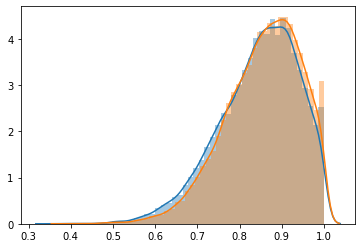

In [51]:
sns.distplot(ndcgs_collaborative)
sns.distplot(ndcgs_content)
plt.show()

In [52]:
alpha = 0.01
p_value = scipy.stats.ttest_rel(ndcgs_content, ndcgs_collaborative)[1]
print('Уровень значимости:', alpha)
print('p-value:', p_value)
if p_value > alpha:
    print('Различие в среднем значении между выборками отсутствует (нулевая гипотеза подтверждена)')
else:
    print('Есть различие в среднем значении между выборками (нулевая гипотеза опровергнута)')

Уровень значимости: 0.01
p-value: 4.3112730956836776e-101
Есть различие в среднем значении между выборками (нулевая гипотеза опровергнута)


# Пункт 6
Сохраняем необходимые для дальнейших предсказаний структуры в файлы

In [53]:
import pickle
import os

if not os.path.exists('res/'):
    os.mkdir('res/')

movie.merge(movie_features, on='movieId_').to_pickle('res/movie.pkl')
pickle.dump(model_collaborative, open('res/model_collaborative.pkl', 'wb'))
model.save_model('res/model.pmml')
pickle.dump(movie_index_to_id, open('res/movie_index_to_id.pkl', 'wb'))
pickle.dump(movie_id_to_index, open('res/movie_id_to_index.pkl', 'wb'))
pickle.dump(feats, open('res/feats.pkl', 'wb'))

Чтобы получить рекоммендацию для пользователя по списку фильмов и их оценок, необходимо
1. Сохранить оценки в csv файл (пример: *watched.csv*) с полями **movieId** и **rating**
2. Выполнить recommend.py \[название csv файла\] \[количество фильмов для рекоммендации\]

### Оценка асимптотики выполнения recommend.py
1. Чтение исходных файлов - O(1)
2. Подмена id фильмов - O(n), где n - длина списка фильмов пользователя
3. ALS для преобразования списка оценок фильмов в вектор скрытых признаков пользователя - O(n + f^2) = O(n), где f - количество скртых признаков (константа)
4. Присоединение скрытых признаков пользователя - O(N), где N - общее количество фильмов
5. Перемножение вектора скрытых признаков пользователя с матрицей скрытых признаков фильмов - O(f * N) = O(N)
6. Предсказание с использованием lightgbm - O(N * T * d), где T - количество деревьев в бустинговой модели, d - максимальная глубина дерева
7. Сортировка предсказанных значений - O(NlogN)

Итого: O(N * T * d + NlogN)